In [75]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
from PIL import Image

(np.float64(-0.5), np.float64(719.5), np.float64(1040.5), np.float64(-0.5))

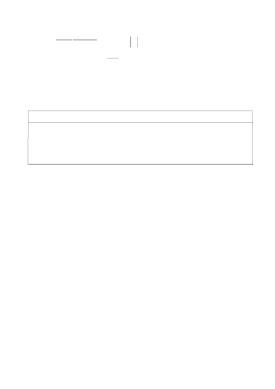

In [76]:
def detect_lines(image_path):
    # Read image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Thresholding the image
    _, binary = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

    # Create kernels for horizontal and vertical line detection
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 30))
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 1))

    # Detect vertical lines
    vertical_lines = cv2.erode(binary, vertical_kernel, iterations=1)
    vertical_lines = cv2.dilate(vertical_lines, vertical_kernel, iterations=1)

    # Detect horizontal lines
    horizontal_lines = cv2.erode(binary, horizontal_kernel, iterations=1)
    horizontal_lines = cv2.dilate(horizontal_lines, horizontal_kernel, iterations=1)

    # Combine the results
    combined_lines = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)

    inverted_mask = cv2.bitwise_not(combined_lines)

    # Use the inverted mask to invert the image
    inverted_image = cv2.bitwise_not(combined_lines)
    result = cv2.bitwise_and(inverted_image, inverted_image, mask=inverted_mask)

    # # Display results
    # plt.figure(figsize=(12, 4))
    # plt.subplot(1, 2, 1)
    # plt.title('Original image')
    # plt.imshow(img, cmap='gray')
    # plt.axis('off')

    # plt.subplot(1, 2, 2)
    # plt.title('Table Structure')
    # plt.imshow(result, cmap='gray')
    # plt.axis('off')

    # plt.tight_layout()
    # plt.show()

    return result
# Example usage
image_path = r"D:\python_testing_vs_code\tabldetect\test_png.png"
res=detect_lines(image_path)
cv2.imwrite("table_st.jpg",res)


plt.imshow(res, cmap='grey')
plt.axis("off")

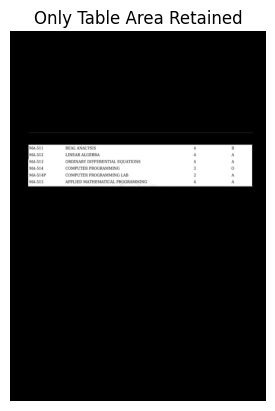

True

In [77]:
# Load the image (grayscale)
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

image_for_contours=image.copy()

# Threshold to get binary image of the table structure
_, binary = cv2.threshold(image_for_contours, 200, 255, cv2.THRESH_BINARY_INV)

# Find contours to detect outer table boundary
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Assume the largest contour is the table
table_contour = max(contours, key=cv2.contourArea)

# Create mask: white inside table, black outside
mask = np.zeros_like(image)
cv2.drawContours(mask, [table_contour], -1, 255, thickness=cv2.FILLED)

# Apply mask to original image
masked = np.where(mask==255,image,0).astype(np.uint8)

# Display results
plt.imshow(masked, cmap='gray')
plt.title("Only Table Area Retained")
plt.axis('off')
plt.show()

# Save output
cv2.imwrite('masked.jpg', masked)


In [78]:
def crop_and_enlarge_table(input_path, output_path, scale_factor=1.5):
    # Read the image
    img = cv2.imread(input_path)
    if img is None:
        raise FileNotFoundError(f"Image not found at {input_path}")

    # Convert to grayscale and threshold to isolate the table (assuming black background)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)  # Threshold >1 to keep non-black pixels

    # Find contours of the table
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        raise ValueError("No table found (could not detect non-black regions).")

    # Get the bounding box of the largest contour (the table)
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Crop the table
    cropped_table = img[y:y+h, x:x+w]

    # Enlarge the table using interpolation
    enlarged_table = cv2.resize(
        cropped_table,
        None,
        fx=scale_factor,
        fy=scale_factor,
        interpolation=cv2.INTER_LINEAR
    )

    # Save the result
    cv2.imwrite(output_path, enlarged_table)
    print(f"Saved cropped and enlarged table to {output_path}")

# Example usage
input_image = "masked.jpg"  # Path to your image (black background + table)
output_image = "cropped.png"  # Output path
crop_and_enlarge_table(input_image, output_image, scale_factor=1.5)

Saved cropped and enlarged table to cropped.png


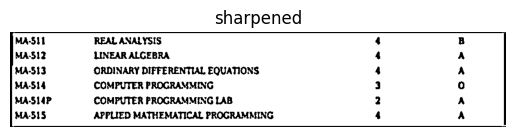

True

In [79]:
# Load image in grayscale
image = cv2.imread("cropped.png", cv2.IMREAD_GRAYSCALE)

# Optional: Apply Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(image, (3, 3), 0)

# Apply adaptive thresholding to darken text
# This turns text pure black and background pure white
dark_text = cv2.adaptiveThreshold(
    blurred,
    maxValue=255,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_MEAN_C,
    thresholdType=cv2.THRESH_BINARY_INV,
    blockSize=15,
    C=10
)

# Invert to make text black on white background (if needed)
result = cv2.bitwise_not(dark_text)

# Show the result
plt.imshow(result, cmap='gray')
plt.axis('off')
plt.title("sharpened")
plt.show()

# Save the result if needed
cv2.imwrite("sharpened.png", result)

In [80]:
# Read image
img = cv2.imread('cropped.png')

# Resize for super-resolution (optional)
resized = cv2.resize(img, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

# High-boost sharpening kernel (5x5)
kernel = np.array([[ -1, -1, -1, -1, -1],
                   [ -1,  2,  2,  2, -1],
                   [ -1,  2,  9,  2, -1],
                   [ -1,  2,  2,  2, -1],
                   [ -1, -1, -1, -1, -1]]) / 8.0  # Normalizing

# Apply filter
sharpened = cv2.filter2D(resized, -1, kernel)

# Save result
cv2.imwrite('enhanced.png', sharpened)


True

In [81]:
pytesseract.pytesseract.tesseract_cmd = r"D:\shape and orientation\tesseract.exe"

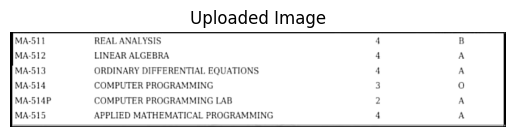

🔍 Extracted Text:

MA-511
MA-512
MA-513

MA-514
MA-514P
MA-515

REAL ANALYSIS

LINEAR ALGEBRA

ORDINARY DIFFERENTIAL EQUATIONS
COMPUTER PROGRAMMING

COMPUTER PROGRAMMING LAB

APPLIED MATHEMATICAL PROGRAMMING




In [82]:
import pytesseract
image = cv2.imread("enhanced.png")
# Convert BGR to RGB (for visualization and pytesseract)
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Step 5: Run OCR
text = pytesseract.image_to_string(rgb)

# Step 6: Show image and extracted text
plt.imshow(rgb)
plt.axis('off')
plt.title('Uploaded Image')
plt.show()

print("🔍 Extracted Text:\n")
print(text)

'apt' is not recognized as an internal or external command,
operable program or batch file.


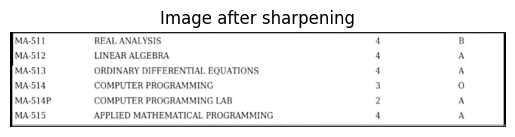

🔍 Extracted Text:

MA-511
MA-512
MA-513

MA-514
MA-514P
MA-515

REAL ANALYSIS

LINEAR ALGEBRA

ORDINARY DIFFERENTIAL EQUATIONS
COMPUTER PROGRAMMING

COMPUTER PROGRAMMING LAB

APPLIED MATHEMATICAL PROGRAMMING




In [83]:
# Step 1: Install required packages
!apt install tesseract-ocr -y
!pip install pytesseract opencv-python Pillow

# Step 2: Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# Step 3: Import libraries
import cv2
import pytesseract
from PIL import Image
import matplotlib.pyplot as plt

# Step 4: Load image from Google Drive
image_path = "enhanced.png"
image = cv2.imread(image_path)

# Convert BGR to RGB
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Step 5: Run OCR
text = pytesseract.image_to_string(rgb)

# Step 6: Display image and extracted text
plt.imshow(rgb)
plt.axis('off')
plt.title('Image after sharpening')
plt.show()

print("🔍 Extracted Text:\n")
print(text)